In [1]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
from sympy import Symbol, exp, sqrt, pi, Integral
from scipy.integrate import quad
from scipy.special import erf

import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda")
# device = torch.device("cpu")

In [2]:
xx=[]
tx_snr = []
H_f = 0.02515203629600967
H_n = 0.40100521298869124
# H_n=0.10025130324717278
# H_f=0.04455613477652123
# H_f = 0.0402704167
# H_n = 0.367564136
# H_n = 0.3290121010789907
# H_f = 0.0395428085386695

snr = 60
for EbN0 in range(1,snr):
    #print([EbN0, H_f, H_n])
    xx.append([EbN0, H_f, H_n])
    tx_snr.append(math.pow(10,(EbN0/10)))
xx = torch.tensor(np.array(list(np.float_(xx)))).to(device)

In [3]:
m =nn.ReLU()
hidden = 8
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.fc1 = nn.Linear(3,hidden)
        self.fc2 = nn.Linear(hidden,hidden)
        self.fc3 = nn.Linear(hidden,hidden)
#         self.fc4 = nn.Linear(hidden,hidden)
#         self.fc5 = nn.Linear(hidden,hidden)
#         self.fc6 = nn.Linear(hidden,hidden)
        self.fc7 = nn.Linear(hidden,1)
    def forward(self, x):
        x = x.float()
        x = m(self.fc1(x))
        x = m(self.fc2(x))
        x = m(self.fc3(x))
#         x = m(self.fc4(x))
#         x = m(self.fc5(x))
#         x = m(self.fc6(x))
        x = m(self.fc7(x))
        return x


In [4]:
model=mlp().to(device)

# loading_model = "./output/model_20210719.pth"
loading_model = "./output/model_20221121_3881.pth"
model = torch.load(loading_model)
loss_fn = nn.MSELoss()

In [5]:
model.eval()
with torch.no_grad():
    output = model(xx).squeeze() #Different dimension may cause wrong results of backpropagation(Something called broadcasting)
#print(output/100)

In [6]:
def theory_f(tx_snr, H_f, p_n):
    return 0.25*(math.erfc(0.5*H_f*np.sqrt(tx_snr))+math.erfc((1-p_n-0.5)*H_f*np.sqrt(tx_snr)))

def theory_n(tx_snr, H_n, p_n):
    return 0.5*math.erfc(p_n*H_n/2*np.sqrt(tx_snr))

def theory_n_ip(tx_snr, H_n, p_n):
    x= Symbol('x')
    f = 1/sqrt(pi)*exp(-x**2)
    result = Integral(f,(x,H_n*(2*(1-p_n)- p_n)/2*sqrt(tx_snr),math.inf)) + Integral(f, (x, H_n*(p_n-2)/2*sqrt(tx_snr), -1/2*sqrt(tx_snr)*H_n))
    result = result.doit().evalf()/2
    result = (1-theory_f(tx_snr, H_n, p_n))*theory_n(tx_snr, H_n, p_n) + (theory_f(tx_snr, H_n, p_n) - result)
    return result

In [7]:
def FTPC(tx_snr, H_f, H_n, a):
    N0 = 1/np.log10(tx_snr)
    p_f = 1/((H_f/N0+H_n/N0)**(-a))*(H_f/N0)**(-a)
    p_n = 1/((H_f/N0+H_n/N0)**(-a))*(H_n/N0)**(-a)
    p_n = p_n/(p_f+p_n)
    return p_n

In [8]:
def qfunc(x):
    return 0.5-0.5*erf(x/np.sqrt(2))
def C(x):
    return np.log2(1+x)
def V(x):
    return (1-1/((1+x)**2))*np.log2(np.exp(1))**2
def n(x):
    t = 128
    err= 1e-5
    qe=qfunc(err)
    return np.sqrt((4*C(x)*qe**2*t+V(x)) + np.sqrt(V(x)))/(2*C(x)*qe)**2
def FBL(tx_snr, H_f, H_n):
    p_n =[]
    for i in range(1, 500):
        p_n.append(i/1000)
    N0 = 1/np.log10(tx_snr)
    t = np.zeros(500)
    for i in range(1,500):
        j = i-1
        sinr_n = (p_n[j]*H_n**2)/N0
        sinr_f = ((1-p_n[j])*H_f**2)/(p_n[j]*H_f**2+N0)
        
        #print(sinr_n, sinr_f)
        t[j]=n(sinr_n) + n(sinr_f)
    return p_n[np.argmin(t[0:499])]

In [9]:
proposed_F_BER = []
proposed_N_BER = []
proposed_NI_BER = []
proposed_avg_BER = []
fixed_F_BER = []
fixed_N_BER = []
fixed_NI_BER = []
fixed_avg_BER = []
fixed_avg_BER_03= []

FTPC_avg_BER = []
FBL_avg_BER = []
for i in range(1,snr):
    #print([EbN0, H_f, H_n])
    EbN0 = i-1
    p_n = output[EbN0]/100
    #proposed_F_BER.append(theory_f(tx_snr[EbN0], H_f, p_n))
    #proposed_N_BER.append(theory_n(tx_snr[EbN0], H_n, p_n))
    #proposed_NI_BER.append(theory_n_ip(tx_snr[EbN0], H_n, p_n))
    p_n = p_n.to('cpu').numpy()
    N0 = 1/tx_snr[EbN0]
    sinr_n = (p_n*H_n**2)/N0
    sinr_f = ((1-p_n)*H_f**2)/(p_n*H_f**2+N0)
    proposed_avg_BER.append(C(sinr_n)+C(sinr_f))
    
    p_n = 0.2
    #fixed_F_BER.append(theory_f(tx_snr[EbN0], H_f, p_n))
    #fixed_N_BER.append(theory_n(tx_snr[EbN0], H_n, p_n))
    #fixed_NI_BER.append(theory_n_ip(tx_snr[EbN0], H_n, p_n))
    sinr_n = (p_n*H_n**2)/N0
    sinr_f = ((1-p_n)*H_f**2)/(p_n*H_f**2+N0)
    fixed_avg_BER.append(C(sinr_n)+C(sinr_f))
     
    p_n= 0.3
    sinr_n = (p_n*H_n**2)/N0
    sinr_f = ((1-p_n)*H_f**2)/(p_n*H_f**2+N0)
    fixed_avg_BER_03.append(C(sinr_n)+C(sinr_f))
    
    p_n = FTPC(tx_snr[EbN0], H_f, H_n, a=0.4)
    sinr_n = (p_n*H_n**2)/N0
    sinr_f = ((1-p_n)*H_f**2)/(p_n*H_f**2+N0)
    FTPC_avg_BER.append(C(sinr_n)+C(sinr_f))
    
    p_n = FBL(tx_snr[EbN0], H_f, H_n)
    sinr_n = (p_n*H_n**2)/N0
    sinr_f = ((1-p_n)*H_f**2)/(p_n*H_f**2+N0)
    FBL_avg_BER.append(C(sinr_n)+C(sinr_f))
    

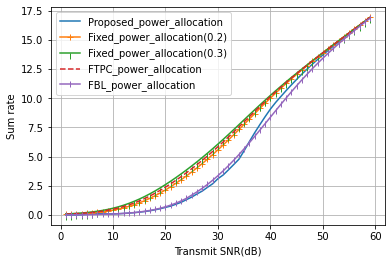

In [10]:
plt.figure()
#plt.plot(proposed_F_BER)
#plt.plot(proposed_N_BER)
#plt.plot(proposed_NI_BER)
EbN0 = range(1,snr)
plt.plot(EbN0, proposed_avg_BER)

#plt.plot(fixed_F_BER)
#plt.plot(fixed_N_BER)
#plt.plot(fixed_NI_BER)
plt.plot(EbN0, fixed_avg_BER,'-+')
plt.plot(EbN0, fixed_avg_BER_03, marker=3)

plt.plot(EbN0, FTPC_avg_BER, '--')

plt.plot(EbN0, FBL_avg_BER, '-|')

plt.legend(['Proposed_power_allocation','Fixed_power_allocation(0.2)','Fixed_power_allocation(0.3)','FTPC_power_allocation', 'FBL_power_allocation'])
#plt.legend(['Proposed_power_alloc(FU)' ,'Proposed_power_alloc(NU with perfect SIC)','Proposed_power_alloc(NU with imperfect SIC)','Proposed_power_alloc(average BER)', 'Fixed_power_alloc(FU)','Fixed_power_alloc(NU with perfect SIC)','Fixed_power_alloc(NU with imperfect SIC)','Fixed_power_alloc(average BER)'])
#plt.ylim((10^(-1), 10^(0)))

plt.xlabel('Transmit SNR(dB)') #(x 1000)')
plt.ylabel('Sum rate')
# plt.semilogy()
plt.grid(True)
#plt.ylim(0,1000)
plt.show()
loss_temp = 0

In [11]:
for i in range(len(proposed_avg_BER)):
    print(proposed_avg_BER[i])

0.001148544843665611
0.0014457833229039353
0.0018198973410182278
0.018011080057024023
0.0451942732469477
0.08083599552959074
0.10264095483451854
0.09904007033970386
0.08574304763014812
0.08158640289911105
0.10067682392903869
0.12558550827364082
0.15483221564350907
0.19205946922447129
0.23658232888782948
0.28797509909131624
0.3543623316302992
0.4394247165460776
0.5316113916338574
0.6480899729482829
0.7597152803791871
0.9209301810117848
1.0854912235444496
1.313750952109412
1.5325206441653214
1.7990691123455114
2.047860334270162
2.371235481296145
2.67581171322812
3.111297702783939
3.430007701517577
3.86900478010256
4.320320117489177
4.783165600083638
5.51705664652542
6.300988873359582
7.053439970194449
7.757117845067365
8.4357199539362
9.083522043137197
9.654609288973115
10.163732140654854
10.672234387005147
11.158641418342228
11.630719114191681
12.085236438551185
12.516814874162433
12.933434044002093
13.339726185558519
13.730783993773612
14.113991249363274
14.484438647666845
14.848338007

In [12]:
for i in range(len(proposed_avg_BER)):
    print(fixed_avg_BER[i])

0.058179568545049604
0.07288047970756178
0.09118397038707915
0.11391168579835424
0.14204036922461646
0.1767147179307443
0.21925279639246786
0.27113952013799897
0.3340032240950026
0.4095707873462024
0.49959878784329564
0.6057820889295484
0.7296468931554638
0.8724414556419744
1.0350422120545264
1.2178936910599254
1.4209959044316487
1.6439436907677214
1.8860115940802573
2.14626894555101
2.4237054848038033
2.7173485109387197
3.026356642930074
3.3500804966332964
3.688085158384705
4.040132605313187
4.406124639899865
4.786009536830835
5.179659472981648
5.586731261494225
6.006529089480636
6.4378927868094085
6.879135978019973
7.3280533388488625
7.782005099256666
8.238072249485231
8.693261455033094
9.144728312963787
9.589983911798466
10.027053569968784
10.454567158350175
10.871774854470825
11.278496631100824
11.675024397551738
12.062000174164098
12.440292028080147
12.810883726339249
13.174786885366988
13.5329780363617
13.886358628839504
14.235733701680118
14.581804311254132
14.92516919014075
15.

In [13]:
for i in range(len(proposed_avg_BER)):
    print(fixed_avg_BER_03[i])

0.08586478780091589
0.10730353994208003
0.1338565244953509
0.16661758406670893
0.20685102195175517
0.2559877543900966
0.31560559284478806
0.38738886752949975
0.47306418326367133
0.5743125533609088
0.6926634500578843
0.8293825090556131
0.9853698050733101
1.1610873822874113
1.3565313797269034
1.5712558439720663
1.804444615779365
2.0550181656652016
2.3217569478131184
2.603422699970409
2.8988629391401517
3.2070893644957668
3.5273258271490215
3.8590247822056134
4.20185262655111
4.555644780883783
4.920331930257385
5.2958406307862615
5.681975256645913
6.078293885790164
6.483996865059549
6.89785091502312
7.318170752374535
7.742872373970989
8.169597951074097
8.595895359124466
9.01942127287046
9.438130608793973
9.85041922098221
10.255199581768808
10.651905973896973
11.040440783142184
11.421082603651387
11.79437879069516
12.16104130912103
12.52185810107309
12.877625451493206
13.22910163688801
13.576979023692605
13.92187047896004
14.264305888608222
14.604735171219293
14.94353500361728
15.281017286

In [14]:
for i in range(len(proposed_avg_BER)):
    print(FTPC_avg_BER[i])

0.07162284015936468
0.08961574248083445
0.11196060097151884
0.13961962649628018
0.17372116065174678
0.21556535005883562
0.2666181083967836
0.3284883728916456
0.4028840429523513
0.4915438805439133
0.5961464610347962
0.718202817685267
0.8589456048325438
1.019232343337218
1.199481238509852
1.3996537388998387
1.6192890505895858
1.8575850048487885
2.1135106687577094
2.3859315995015873
2.6737292100570214
2.97589984728946
3.2916245289464463
3.620304885534468
3.9615638324860103
4.315211092210263
4.681174867716644
5.05940295035567
5.449740247528634
5.8517952535792155
6.264814248264648
6.6875866522893315
7.118405124680109
7.555097601226923
7.9951357093445194
8.435807733255603
8.874429276140901
9.308555725637992
9.736160508716516
10.155751953457715
10.566416473231993
10.967792002235193
11.359988350163414
11.743477422019492
12.118975790994378
12.487336893083842
12.8494630001018
13.206240553127072
13.558497724951696
13.906980484301865
14.25234255745192
14.595144904420275
14.935861086788952
15.27488

In [15]:
for i in range(len(proposed_avg_BER)):
    print(FBL_avg_BER[i])

0.010138546743694382
0.013117660588345603
0.016498471205503604
0.020745562670407697
0.026077992233158643
0.03366966592346961
0.042284423260066074
0.053070706417370016
0.06655748567100156
0.083392406867796
0.10436292088278618
0.1304182501945931
0.16269052397010964
0.2025125075699133
0.2514283366460113
0.3111927498905094
0.3837538729589011
0.4712151646121038
0.5757742399398585
0.6996402071474214
0.8449364865601968
1.0136014316065871
1.2073022184272053
1.4273762168032513
1.7016577124843364
1.9792476108302084
2.2849630605360707
2.6188144852709097
2.980556189859847
3.369671648872445
3.785332496997863
4.226344331548587
4.691098447975632
5.177547605840534
5.683216638165523
6.2052485168263765
6.7404776765658285
7.28551816681192
7.836855299931207
8.390934332127927
8.944245612223481
9.493409942909143
10.035268924578736
10.56698232990679
11.08612890570336
11.590800419890702
12.079674024040592
12.552047631784692
13.007828064672372
13.44747088656817
13.87188086903296
14.28228927502568
14.6801264409

In [16]:
for i in range(len(tx_snr)):
    p_n = output[i]/100
    print(p_n)
    print('TX_SNR :', tx_snr[i])
    print('FU : ', theory_f(tx_snr[i], H_f, p_n))
    print('NU with PSIC : ', theory_n(tx_snr[i], H_n, p_n))
    print('NU with ISIC : ', theory_n_ip(tx_snr[i], H_n, p_n))

tensor(0., device='cuda:0')
TX_SNR : 1.2589254117941673
FU :  0.49203951722696804
NU with PSIC :  0.5
NU with ISIC :  0.499999999450899
tensor(0., device='cuda:0')
TX_SNR : 1.5848931924611136
FU :  0.49106834491427864
NU with PSIC :  0.5
NU with ISIC :  0.499999999183947
tensor(0., device='cuda:0')
TX_SNR : 1.9952623149688795
FU :  0.48997873486425825
NU with PSIC :  0.5
NU with ISIC :  0.499999999941540
tensor(0.0272, device='cuda:0')
TX_SNR : 2.51188643150958
FU :  0.4890623815938998
NU with PSIC :  0.49511774330909913
NU with ISIC :  0.495621045575174
tensor(0.0588, device='cuda:0')
TX_SNR : 3.1622776601683795
FU :  0.48812589262308903
NU with PSIC :  0.48818028034965133
NU with ISIC :  0.489681058670966
tensor(0.0862, device='cuda:0')
TX_SNR : 3.9810717055349722
FU :  0.4870661839235147
NU with PSIC :  0.48054485907042194
NU with ISIC :  0.483543092344293
tensor(0.0877, device='cuda:0')
TX_SNR : 5.011872336272722
FU :  0.48551124513048427
NU with PSIC :  0.47781405839734087
NU with